**High Capacity Peers - Top 20 Nodes**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading files...
TIME file exists: True  |  FREQ file exists: True
TIME sha256: 306e372bd873aa75d9e2d5bfc374530776891f7fdeb636b95a71fefc82989894
FREQ sha256: 9dce8fe67be0dac36a858ca7f4c8f7345221dfb09c1f5645f80aef58672d5f4a

Totals → time-log: 629,936  |  freq-file: 22,317

Prefix check 'Z1bh': 1 ID(s), total appearances = 3,926
Most frequent full ID with this prefix: ('Z1bh-f140eBV-XG4GVbx7zlB0xCCOLa~3AsBk9Vw~Dc=', 3926)


,peer_id_short,freq,pct,other_count,delta
0,Z1bh-f14...,3926,0.6,13,3913
1,srLHIzJ8...,3799,0.6,2,3797
2,moCfkmqX...,3576,0.6,47,3529
3,TDQO~djJ...,3369,0.5,43,3326
4,IojVH~dn...,3186,0.5,2,3184
5,onjR2Et2...,2838,0.5,3,2835
6,tlVPuTPT...,2760,0.4,62,2698
7,KM68Y3Pl...,2753,0.4,1,2752
8,opSZwy-w...,2751,0.4,74,2677
9,Zf30eTRP...,2740,0.4,5,2735


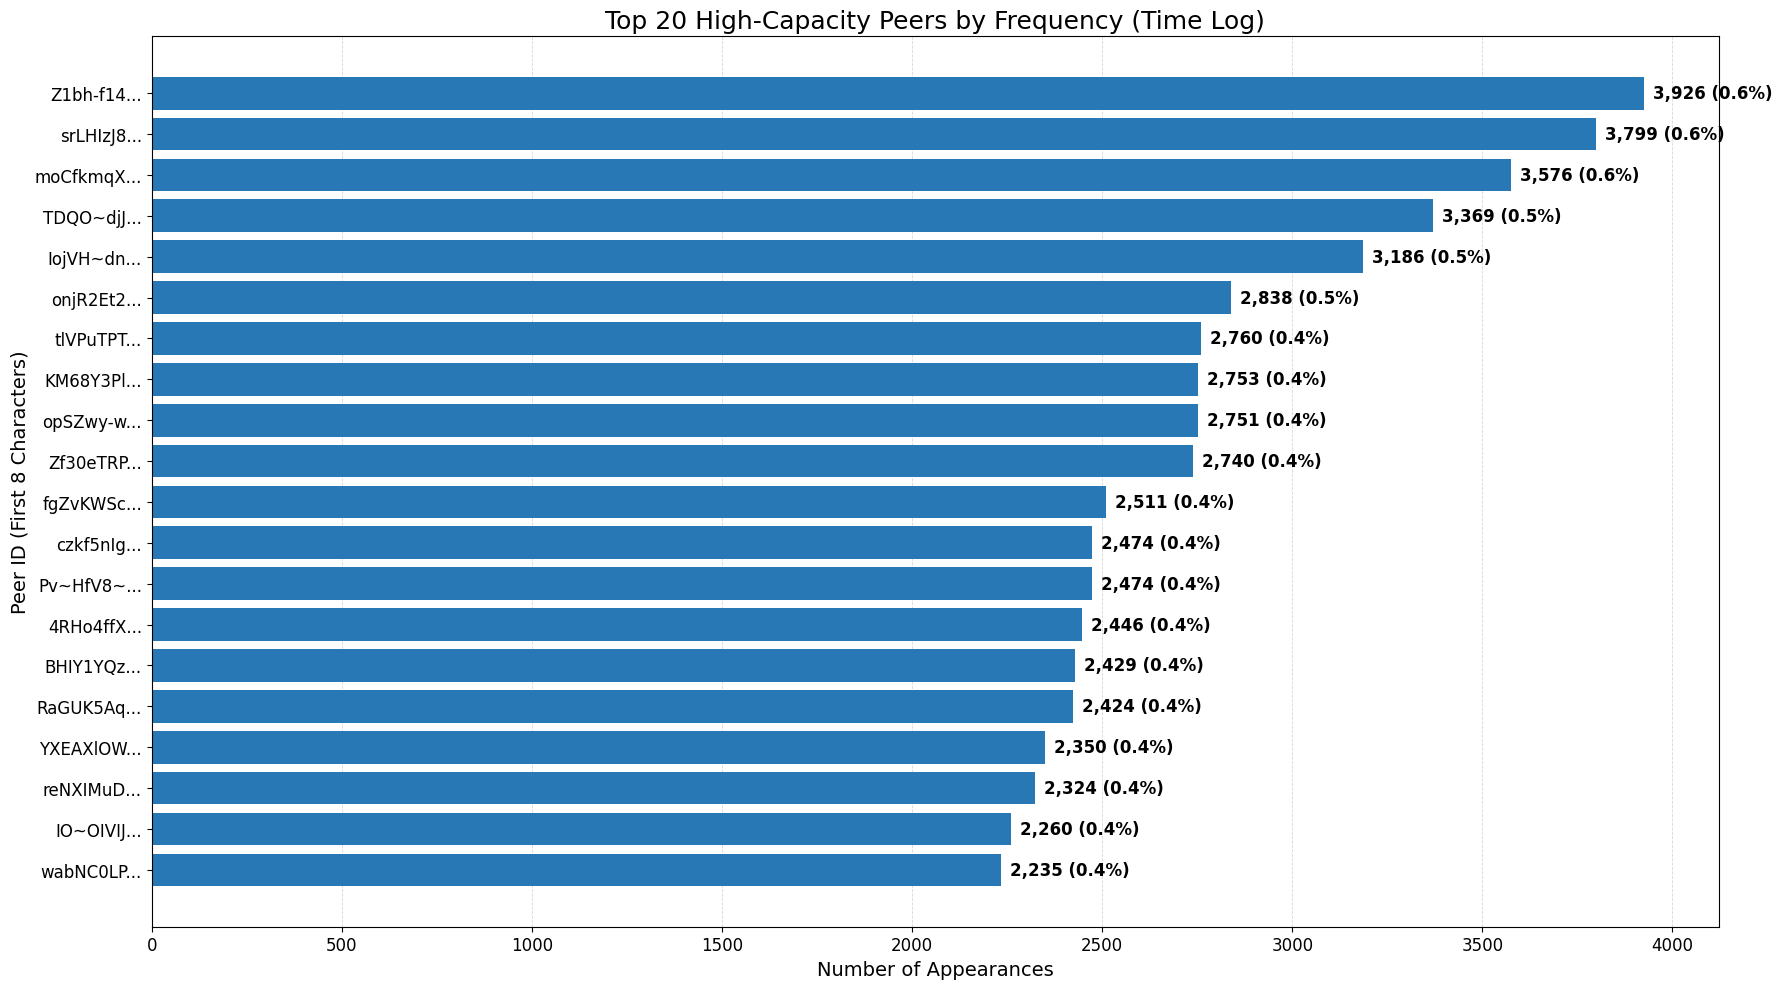


Saved chart to: /content/drive/MyDrive/DataInBrief-2025/HighCapacityTop20.png
Plotted source = 'time'  |  Percentages computed over that source’s total.


In [2]:
# ============================================
# Top-20 High-Capacity peers (Colab, matplotlib)
# Uses BOTH files for verification:
#   - Time-log source of truth: 6-High-Capacity-Set.txt
#   - Pre-counts file:          7-High-Capacity-Set-Freq.txt
# Produces a blue bar chart with count + percentage labels.
# ============================================
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

from pathlib import Path
import re, hashlib
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths (exact) ----
PATH_TIME = Path("/content/drive/MyDrive/DataInBrief-2025/6-High-Capacity-Set.txt")
PATH_FREQ = Path("/content/drive/MyDrive/DataInBrief-2025/7-High-Capacity-Set-Freq.txt")
OUT_PNG   = Path("/content/drive/MyDrive/DataInBrief-2025/HighCapacityTop20.png")

# ---- Config ----
TOP_N       = 20
SHORT_CHARS = 8          # show first 8 chars then "..."
MIN_LEN_ID  = 24         # minimum token length to treat as a node ID in the time-log
USE_SOURCE  = "time"     # options: "time" | "freq"
CHECK_PREFIX = "Z1bh"    # quick sanity check like your screenshot label

# ---- Helpers ----
def sha256_of(path: Path) -> str:
    data = path.read_bytes()
    return hashlib.sha256(data).hexdigest()

def read_freq_file(path: Path) -> Counter:
    """Parse (node, count) in flexible formats, aggregate duplicates."""
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    freq = Counter()
    pat_pairs = [
        re.compile(r"^\s*([^\s,:;|]+)\s*[:|,;\t ]+\s*(\d+)\s*$"),   # node first
        re.compile(r"^\s*(\d+)\s*[:|,;\t ]+\s*([^\s,:;|]+)\s*$"),   # count first
    ]
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            s = raw.strip()
            if not s:
                continue
            m = None
            for pat in pat_pairs:
                m = pat.match(s)
                if m:
                    break
            if m:
                a, b = m.groups()
                if a.isdigit():
                    node, cnt = b, int(a)
                else:
                    node, cnt = a, int(b)
                freq[node] += cnt
                continue
            parts = re.split(r"[:|,;\t ]+", s)
            ints  = [p for p in parts if p.isdigit()]
            toks  = [p for p in parts if p and not p.isdigit()]
            if ints and toks:
                freq[toks[0]] += int(ints[-1])
    return freq

# Node IDs: base64-like tokens including A–Z a–z 0–9 and ~ - _
NODE_RE = re.compile(r"[A-Za-z0-9~\-_]+={0,2}")

def count_from_time_log(path: Path, min_len: int = 24) -> Counter:
    """Extract node IDs from the time-log and count raw appearances."""
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    text = path.read_text(encoding="utf-8", errors="ignore")
    tokens = NODE_RE.findall(text)
    tokens = [t for t in tokens if len(t) >= min_len]
    return Counter(tokens)

# ---- Load both sources ----
print("Reading files...")
print(f"TIME file exists: {PATH_TIME.exists()}  |  FREQ file exists: {PATH_FREQ.exists()}")
if PATH_TIME.exists():
    print("TIME sha256:", sha256_of(PATH_TIME))
if PATH_FREQ.exists():
    print("FREQ sha256:", sha256_of(PATH_FREQ))

counts_time = count_from_time_log(PATH_TIME, MIN_LEN_ID)
counts_freq = read_freq_file(PATH_FREQ)

total_time = sum(counts_time.values())
total_freq = sum(counts_freq.values())
print(f"\nTotals → time-log: {total_time:,}  |  freq-file: {total_freq:,}")

# ---- Optional: show any mismatches for top nodes (by chosen source later) ----
def top_df(counts: Counter, total: int, top_n: int):
    ranked = counts.most_common(top_n)
    df = pd.DataFrame({
        "peer_id_full": [n for n,_ in ranked],
        "freq": [c for _,c in ranked],
    })
    df["pct"] = (df["freq"] / total * 100.0).round(1) if total > 0 else 0.0
    df["peer_id_short"] = [f"{n[:SHORT_CHARS]}..." for n in df["peer_id_full"]]
    return df

# Choose source to PLOT and compute percent-of-total
if USE_SOURCE == "freq":
    src_counts, src_total = counts_freq, total_freq
else:
    src_counts, src_total = counts_time, total_time

df_top = top_df(src_counts, src_total, TOP_N)

# Compare with the other file for sanity (won't affect plot)
other_counts = counts_freq if USE_SOURCE == "time" else counts_time
df_top["other_count"] = df_top["peer_id_full"].map(other_counts).fillna(0).astype(int)
df_top["delta"] = df_top["freq"] - df_top["other_count"]

# Spot-check prefix like "Z1bh"
subset = [(n,c) for n,c in src_counts.items() if n.startswith(CHECK_PREFIX)]
subset_total = sum(c for _,c in subset)
print(f"\nPrefix check '{CHECK_PREFIX}': {len(subset)} ID(s), total appearances = {subset_total:,}")
if subset:
    # show the single most frequent matching full ID
    print("Most frequent full ID with this prefix:",
          sorted(subset, key=lambda x: x[1], reverse=True)[0])

# Display the table (short id, count, %, and the other file’s count for comparison)
display(df_top[["peer_id_short","freq","pct","other_count","delta"]])

# ---- Plot (blue bars like your example) ----
vals   = df_top["freq"].to_numpy()
labels = df_top["peer_id_short"].tolist()
pcts   = df_top["pct"].to_numpy()

plt.figure(figsize=(18, 10))
y = np.arange(len(vals))
bars = plt.barh(y, vals, color="#2878B5")  # blue
plt.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.5)
plt.gca().set_axisbelow(True)
plt.gca().invert_yaxis()

plt.yticks(y, labels, fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Number of Appearances", fontsize=14)
plt.ylabel("Peer ID (First 8 Characters)", fontsize=14)
title_src = "Time Log" if USE_SOURCE == "time" else "Frequency File"
plt.title(f"Top {TOP_N} High-Capacity Peers by Frequency ({title_src})", fontsize=18)

max_v = int(vals.max()) if len(vals) else 0
for i, (v, pct) in enumerate(zip(vals, pcts)):
    plt.text(v + max(5, max_v * 0.006), i, f"{int(v):,} ({pct:.1f}%)",
             va="center", ha="left", fontsize=12, fontweight="bold")

plt.tight_layout()
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_PNG, dpi=200)
plt.show()

print(f"\nSaved chart to: {OUT_PNG}")
print(f"Plotted source = {USE_SOURCE!r}  |  Percentages computed over that source’s total.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files present: True True
TIME sha256: 306e372bd873aa75d9e2d5bfc374530776891f7fdeb636b95a71fefc82989894
FREQ sha256: 9dce8fe67be0dac36a858ca7f4c8f7345221dfb09c1f5645f80aef58672d5f4a

Totals → time-log: 629,936 | freq-file: 22,317

Prefix 'Z1bh-f14' in TIME-LOG:
  Z1bh-f140eBV-XG4GVbx7zlB0xCCOLa~3AsBk9Vw~Dc=  -> 3926
  TOTAL for prefix in TIME-LOG: 3926

Prefix 'Z1bh-f14' in FREQ-FILE:
  Z1bh-f140eBV-XG4GVbx7zlB0xCCOLa~3AsBk9Vw~Dc=  -> 13
  TOTAL for prefix in FREQ-FILE: 13

TOP-20 row for 'Z1bh-f14': count=3926, pct=0.6%


,peer_id_short,frequency,percentage
0,Z1bh-f14...,3926,0.6
1,srLHIzJ8...,3799,0.6
2,moCfkmqX...,3576,0.6
3,TDQO~djJ...,3369,0.5
4,IojVH~dn...,3186,0.5
5,onjR2Et2...,2838,0.5
6,tlVPuTPT...,2760,0.4
7,KM68Y3Pl...,2753,0.4
8,opSZwy-w...,2751,0.4
9,Zf30eTRP...,2740,0.4


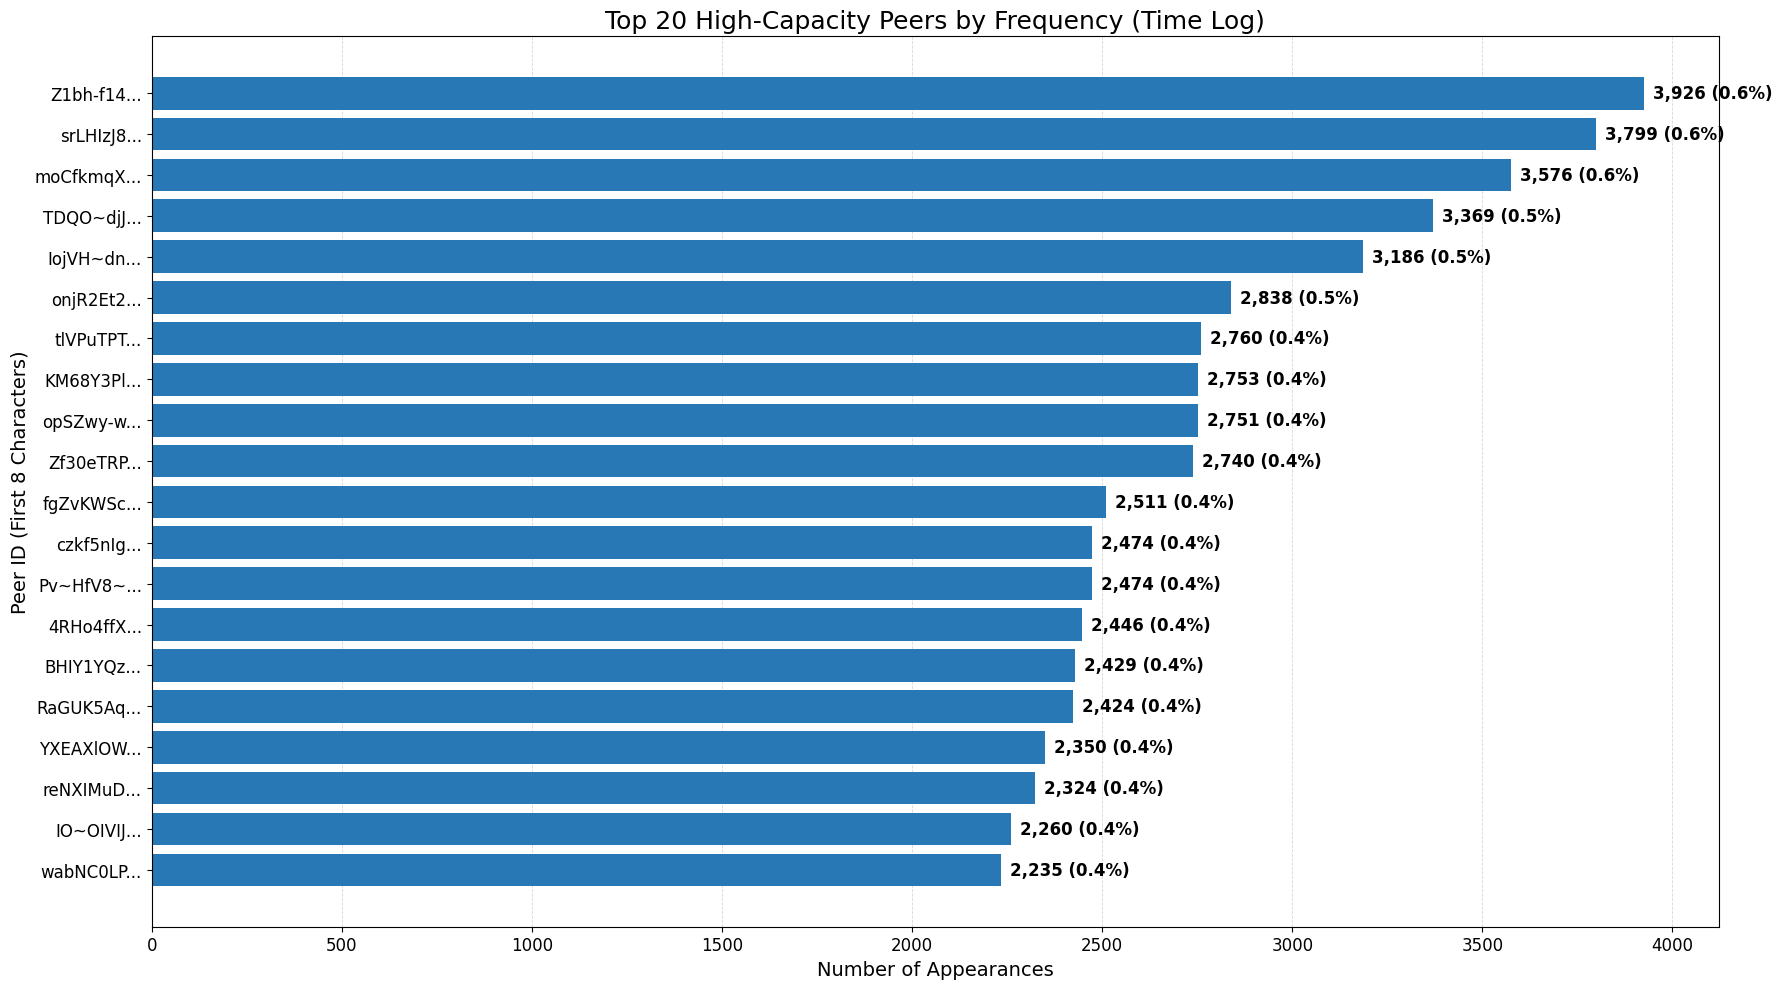


Saved: /content/drive/MyDrive/DataInBrief-2025/HighCapacityTop20.png


In [3]:
# ============================
# Verify Z1bh-f14 and plot Top-20 High-Capacity peers
# ============================
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

from pathlib import Path
import re, hashlib
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- paths ----
PATH_TIME = Path("/content/drive/MyDrive/DataInBrief-2025/6-High-Capacity-Set.txt")
PATH_FREQ = Path("/content/drive/MyDrive/DataInBrief-2025/7-High-Capacity-Set-Freq.txt")
OUT_PNG   = Path("/content/drive/MyDrive/DataInBrief-2025/HighCapacityTop20.png")

# ---- config ----
TOP_N        = 20
SHORT_LEN    = 8                 # show first 8 chars + "..."
PREFIX_CHECK = "Z1bh-f14"        # what you asked to verify
PLOT_SOURCE  = "time"            # "time" or "freq" as the plotting source-of-truth
MIN_LEN_ID   = 24                # filter for node-like tokens in time log

# ---- helpers ----
def sha256sum(p: Path) -> str:
    return hashlib.sha256(p.read_bytes()).hexdigest()

# robust (node,count) parser
def read_freq_file(path: Path) -> Counter:
    if not path.exists():
        raise FileNotFoundError(f"Missing: {path}")
    freq = Counter()
    pat_pairs = [
        re.compile(r"^\s*([^\s,:;|]+)\s*[:|,;\t ]+\s*(\d+)\s*$"),   # node first
        re.compile(r"^\s*(\d+)\s*[:|,;\t ]+\s*([^\s,:;|]+)\s*$"),   # count first
    ]
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            s = raw.strip()
            if not s:
                continue
            m = None
            for pat in pat_pairs:
                m = pat.match(s)
                if m:
                    break
            if m:
                a, b = m.groups()
                if a.isdigit():
                    node, cnt = b, int(a)
                else:
                    node, cnt = a, int(b)
                freq[node] += cnt
                continue
            parts = re.split(r"[:|,;\t ]+", s)
            ints  = [p for p in parts if p.isdigit()]
            toks  = [p for p in parts if p and not p.isdigit()]
            if ints and toks:
                freq[toks[0]] += int(ints[-1])
    return freq

# extract node-like tokens from time-log
NODE_RE = re.compile(r"[A-Za-z0-9~\-_]+={0,2}")
def count_from_time_log(path: Path, min_len: int = 24) -> Counter:
    if not path.exists():
        raise FileNotFoundError(f"Missing: {path}")
    text = path.read_text(encoding="utf-8", errors="ignore")
    toks = [t for t in NODE_RE.findall(text) if len(t) >= min_len]
    return Counter(toks)

# ---- load & verify ----
print("Files present:",
      PATH_TIME.exists(), PATH_FREQ.exists())
if PATH_TIME.exists(): print("TIME sha256:", sha256sum(PATH_TIME))
if PATH_FREQ.exists(): print("FREQ sha256:", sha256sum(PATH_FREQ))

counts_time = count_from_time_log(PATH_TIME, MIN_LEN_ID)
counts_freq = read_freq_file(PATH_FREQ)

total_time = sum(counts_time.values())
total_freq = sum(counts_freq.values())
print(f"\nTotals → time-log: {total_time:,} | freq-file: {total_freq:,}")

# ---- exact prefix verification for Z1bh-f14 ----
def prefix_stats(counter: Counter, prefix: str):
    items = [(n, c) for n, c in counter.items() if n.startswith(prefix)]
    items.sort(key=lambda x: x[1], reverse=True)
    total = sum(c for _, c in items)
    return items, total

items_time, total_pref_time = prefix_stats(counts_time, PREFIX_CHECK)
items_freq, total_pref_freq = prefix_stats(counts_freq, PREFIX_CHECK)

print(f"\nPrefix '{PREFIX_CHECK}' in TIME-LOG:")
if items_time:
    for n,c in items_time[:5]:
        print(f"  {n}  -> {c}")
    print(f"  TOTAL for prefix in TIME-LOG: {total_pref_time}")
else:
    print("  (no matches)")

print(f"\nPrefix '{PREFIX_CHECK}' in FREQ-FILE:")
if items_freq:
    for n,c in items_freq[:5]:
        print(f"  {n}  -> {c}")
    print(f"  TOTAL for prefix in FREQ-FILE: {total_pref_freq}")
else:
    print("  (no matches)")

# ---- choose source for plotting ----
src_counts, src_total = (counts_time, total_time) if PLOT_SOURCE == "time" else (counts_freq, total_freq)

# build top-20 dataframe
ranked = src_counts.most_common(TOP_N)
df = pd.DataFrame({
    "peer_id_full": [n for n,_ in ranked],
    "frequency":    [c for _,c in ranked],
})
df["percentage"]   = (df["frequency"] / src_total * 100.0).round(1) if src_total > 0 else 0.0
df["peer_id_short"] = [f"{n[:SHORT_LEN]}..." for n in df["peer_id_full"]]

# show the row for Z1bh-f14 (if in Top-20)
row = df[df["peer_id_full"].str.startswith(PREFIX_CHECK)]
if not row.empty:
    r = row.iloc[0]
    print(f"\nTOP-20 row for '{PREFIX_CHECK}': count={int(r['frequency'])}, pct={r['percentage']}%")
else:
    print(f"\n'{PREFIX_CHECK}' is not in the Top-{TOP_N} of the selected source ({PLOT_SOURCE}).")

display(df[["peer_id_short","frequency","percentage"]])

# ---- plot (blue bars, count + percentage) ----
vals   = df["frequency"].to_numpy()
labels = df["peer_id_short"].tolist()
pcts   = df["percentage"].to_numpy()

plt.figure(figsize=(18, 10))
y = np.arange(len(vals))
bars = plt.barh(y, vals, color="#2878B5")
plt.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.5)
plt.gca().set_axisbelow(True)
plt.gca().invert_yaxis()
plt.yticks(y, labels, fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Number of Appearances", fontsize=14)
plt.ylabel("Peer ID (First 8 Characters)", fontsize=14)
plt.title(f"Top {TOP_N} High-Capacity Peers by Frequency ({'Time Log' if PLOT_SOURCE=='time' else 'Frequency File'})",
          fontsize=18)

mx = int(vals.max()) if len(vals) else 0
for i, (v, pct) in enumerate(zip(vals, pcts)):
    plt.text(v + max(5, mx * 0.006), i, f"{int(v):,} ({pct:.1f}%)",
             va="center", ha="left", fontsize=12, fontweight="bold")

plt.tight_layout()
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_PNG, dpi=200)
plt.show()

print(f"\nSaved: {OUT_PNG}")
